# Taxi demand prediction in New York City


In [1]:
# Running in Google Colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Data_Notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Data_Notebooks


**Removing all EDA Cells and plotting cells and directly adding features and cleaning the data.**

In [2]:

!pip install gpxpy
import dask.dataframe as dd

import pandas as pd

import folium

import datetime

import time

import numpy as np

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams

import gpxpy.geo

from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os

import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 112kB 2.8MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.3.5-cp36-none-any.whl size=40315 sha256=b18a631aa6b0a64fdc3971423d8aeb804f5297db5667627654801c7c90519a65
  Stored in directory: /root/.cache/pip/wheels/d2/f0/5e/b8e85979e66efec3eaa0e47fbc5274db99fd1a07befd1b2aa4
Successfully built gpxpy


In [3]:
#Looking at the features
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


### Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [0]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

# print(frame_with_durations.head())
#  passenger_count	trip_distance	pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude	total_amount	trip_times	pickup_times	Speed
#   1                  1.59	      -73.993896        	40.750111    	-73.974785      	40.750618           	17.05   	 18.050000	1.421329e+09	5.285319
#   1               	3.30    	-74.001648      	40.724243   	-73.994415      	40.759109           	17.80   	19.833333	1.420902e+09	9.983193
#   1               	1.80     	-73.963341      	40.802788     	-73.951820      	40.824413           	10.80   	10.050000	1.420902e+09	10.746269
#   1               	0.50    	-74.009087      	40.713818    	-74.004326       	40.719986           	4.80    	1.866667	1.420902e+09	16.071429
#   1               	3.00    	-73.971176      	40.762428    	-74.004181      	40.742653           	16.30   	19.316667	1.420902e+09	9.318378
frame_with_durations = return_with_trip_times(month)

## Remove all outliers/erronous points.

**Outliers are removed based on the EDA done in original notebook.**

In [0]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [6]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 24473
Number of outliers from fare analysis: 5275
Total outliers removed 377910
---
fraction of data points that remain after removing outliers 0.9703576425607495


# Data-preperation
## Clustering/Segmentation

In [0]:
#trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
# for increment in range(10, 100, 10):
#     cluster_centers, cluster_len = find_clusters(increment)
#     find_min_distance(cluster_centers, cluster_len)            

### Getting clusters for k=30

In [0]:
# Getting 30 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

## Time-binning

In [0]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    start_pickup_unix=unix_times[year-2015][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [0]:
# clustering, making pickup bins and grouping by pickup cluster and pickup bins
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [11]:
# hear the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: pickup_cluster (cluster number)
# secondary index : pickup_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              33                     138
               34                     262
               35                     311
               36                     325
               37                     381

In [12]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016
def datapreparation(month,kmeans,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    
    print ("Estimating clusters..")
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    #frame_with_durations_outliers_removed_2016['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed_2016[['pickup_latitude', 'pickup_longitude']])

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan_2016_frame,jan_2016_groupby = datapreparation(month_jan_2016,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)

Return with trip times..
Remove outliers..
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 22437
Number of outliers from fare analysis: 5476
Total outliers removed 308177
---
Estimating clusters..
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers fro

## Smoothing

In [0]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,30):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [0]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)

#feb
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#march
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,30):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [0]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,30):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [0]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,30):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])

# print(len(regions_cum))
# 30
# print(len(regions_cum[0]))
# 13104

## Time series and Fourier Transforms

In [0]:
%matplotlib inline

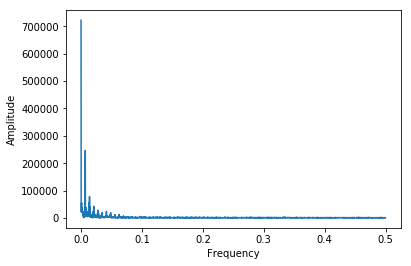

In [19]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [20]:
freq_amp_df = pd.DataFrame(np.array([np.abs(np.real(freq)), np.abs(Y)]).T, columns=['freq', 'amp'])
freq_amp_df.drop_duplicates(inplace=True)
freq_amp_df.sort_values('amp', ascending=False, inplace=True)
freq_amp_df.head()

,freq,amp
0,0.000000,722007.000000
31,0.006951,246726.577980
4398,0.013901,78143.938628
62,0.013901,78143.938628
4402,0.013004,55749.451715


In [21]:
freq_amp_df = freq_amp_df.head()
print(freq_amp_df)

          freq            amp
0     0.000000  722007.000000
31    0.006951  246726.577980
4398  0.013901   78143.938628
62    0.013901   78143.938628
4402  0.013004   55749.451715


### Calculating Fourier data for every 10-min interval

**For each 10-min interval I take prev 7 days data = 1000 rows (~10080 minutes) and find fft values to add fourier features at that 10-min interval. I will take top 5 frequencies and amplitudes and add them to the matrix. So my final `fft_data` matrix size will be 30 \* DF(13104 \* 10)**

In [22]:
freq_amp_cols = []
for i in range(5):
  freq_amp_cols.append('freq_'+str(i))
  freq_amp_cols.append('amp_'+str(i))

print(freq_amp_cols)

['freq_0', 'amp_0', 'freq_1', 'amp_1', 'freq_2', 'amp_2', 'freq_3', 'amp_3', 'freq_4', 'amp_4']


In [23]:
fft_data = []
ind = 0
for reg in regions_cum:
  print(f'cluster {ind} started..')
  fft_data_reg = pd.DataFrame(columns = freq_amp_cols)
  fft_data_reg.loc[0] = [0]*10
  for i in range(1, 13104):
    left_ind = max(0, i-1000)
    Y    = np.fft.fft(np.array(reg)[left_ind:i])
    freq = np.fft.fftfreq(len(Y), 1)
    freq_amp_df = pd.DataFrame(np.array([np.abs(np.real(freq)), np.abs(Y)]).T, columns=['freq', 'amp'])
    freq_amp_df.drop_duplicates(inplace=True)
    freq_amp_df.sort_values('amp', ascending=False, inplace=True)
    freq_amp_df = freq_amp_df.head()
    freq_amp_df = freq_amp_df.values.flatten()
    if len(freq_amp_df)<10:
      extra_zeros = [0]*(10-len(freq_amp_df))
      freq_amp_df = np.append(freq_amp_df, [extra_zeros])
    fft_data_reg.loc[i] = freq_amp_df
  fft_data.append(fft_data_reg)
  print(f'cluster {ind} ended..')
  ind = ind+1

cluster 0 started..
cluster 0 ended..
cluster 1 started..
cluster 1 ended..
cluster 2 started..
cluster 2 ended..
cluster 3 started..
cluster 3 ended..
cluster 4 started..
cluster 4 ended..
cluster 5 started..
cluster 5 ended..
cluster 6 started..
cluster 6 ended..
cluster 7 started..
cluster 7 ended..
cluster 8 started..
cluster 8 ended..
cluster 9 started..
cluster 9 ended..
cluster 10 started..
cluster 10 ended..
cluster 11 started..
cluster 11 ended..
cluster 12 started..
cluster 12 ended..
cluster 13 started..
cluster 13 ended..
cluster 14 started..
cluster 14 ended..
cluster 15 started..
cluster 15 ended..
cluster 16 started..
cluster 16 ended..
cluster 17 started..
cluster 17 ended..
cluster 18 started..
cluster 18 ended..
cluster 19 started..
cluster 19 ended..
cluster 20 started..
cluster 20 ended..
cluster 21 started..
cluster 21 ended..
cluster 22 started..
cluster 22 ended..
cluster 23 started..
cluster 23 ended..
cluster 24 started..
cluster 24 ended..
cluster 25 started..

In [24]:
print(len(fft_data))
print(fft_data[0].shape)

30
(13104, 10)


In [0]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2015_smooth
ratios_jan['Prediction']=jan_2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

**Not Running baseline models except exponential weighted average because it is used in the final model and not using ratios in the final model as they are not providing as good results as previous day`s values.**

## Regression Models

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data and split it such that for every region we have 70% data in train and 30% in test, ordered date-wise for every region

In [0]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,30):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [27]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 30*13099 == len(output)*len(output[0])

True

**Exponential moving averages**

In [0]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,30):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [29]:
for i in range(30):
  fft_data[i] = fft_data[i][5:]
print(len(fft_data))
print(fft_data[0].shape)

30
(13099, 10)


In [30]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,30)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,30)]

In [32]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 30 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 30 Number of data points in test data 3930 Each data point contains 5 features


In [0]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [0]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [0]:
fft_train_data = [i[:9169] for i in fft_data]
fft_test_data = [i[9169:] for i in fft_data]

In [0]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,30):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,30):
    test_new_features.extend(test_features[i])

In [37]:
fft_train_data = pd.concat(fft_train_data, ignore_index=True)
fft_test_data = pd.concat(fft_test_data, ignore_index=True)
print(fft_train_data.shape)
print(fft_test_data.shape)

(275070, 10)
(117900, 10)


In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [0]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [40]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
sum(df_train.index == fft_train_data.index)

275070

In [0]:
df_train_clusters = np.array([[i]*9169 for i in range(30)]).flatten()
df_test_clusters = np.array([[i]*3930 for i in range(30)]).flatten()

In [42]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train = pd.concat([df_train, fft_train_data], axis=1)
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg
df_train['cluster_id'] = df_train_clusters

print(df_train.shape)

(275070, 20)


In [43]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test = pd.concat([df_test, fft_test_data], axis=1)
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
df_test['cluster_id'] = df_test_clusters

print(df_test.shape)

(117900, 20)


In [44]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq_0,amp_0,freq_1,amp_1,freq_2,amp_2,freq_3,amp_3,freq_4,amp_4,lat,lon,weekday,exp_avg,cluster_id
0,271,270,238,269,260,0,178108,0.007,64807.8,0.014,24480.6,0.014,24480.6,0.021,16455.5,40.777809,-73.954054,4,260,0
1,270,238,269,260,281,0,178150,0.007,64845.1,0.007,64845.1,0.014,24469,0.021,16418.3,40.777809,-73.954054,4,274,0
2,238,269,260,281,264,0,178190,0.007,64881.4,0.014,24454.6,0.021,16380.7,0.001,14849.1,40.777809,-73.954054,4,267,0
3,269,260,281,264,286,0,178228,0.007,64916.5,0.007,64916.5,0.014,24437.9,0.021,16343.7,40.777809,-73.954054,4,280,0
4,260,281,264,286,280,0,178249,0.007,64936.3,0.014,24427.1,0.021,16322.7,0.021,16322.7,40.777809,-73.954054,4,280,0


# Assignments

        

In [45]:
'''
Task 1: Incorporate Fourier features as features into Regression models and measure MAPE. <br>

Task 2: Perform hyper-parameter tuning for Regression models.
        2a. Linear Regression: Grid Search
        2b. Random Forest: Random Search 
        2c. Xgboost: Random Search
Task 3: Explore more time-series features using Google search/Quora/Stackoverflow
to reduce the MAPE to < 12%
'''

'\nTask 1: Incorporate Fourier features as features into Regression models and measure MAPE. <br>\n\nTask 2: Perform hyper-parameter tuning for Regression models.\n        2a. Linear Regression: Grid Search\n        2b. Random Forest: Random Search \n        2c. Xgboost: Random Search\nTask 3: Explore more time-series features using Google search/Quora/Stackoverflow\nto reduce the MAPE to < 12%\n'

**As fourier features are included in data in above code blocks, we can go ahead and do second Task.**

### Using Linear Regression

**Before Running linear regression we can see some columns are not linearly related to the output values. Those are cluster_id, weekday, and even latitude and longitude. So it makes sense to encode them before running. We can remove latitude, longitude and cluster id and replace them with one-hot encoding of cluster id. And we can onehot encode the weekday column as well. As our model is Linear regression we can have more dimensions which will not affect our performance. For other tree based models we can neglect encoding for such features.**

**Creating new dataframe for training linear regression and adding onehot encoded data into it.**

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
onehotcoder = OneHotEncoder()
onehotcoder.fit(df_train[['weekday', 'cluster_id']])
# should be 30+7 = 37
print(len(onehotcoder.get_feature_names()))

37


In [0]:
df_ohe_train = onehotcoder.transform(df_train[['weekday', 'cluster_id']])
df_ohe_test = onehotcoder.transform(df_test[['weekday', 'cluster_id']])

In [0]:
from scipy import sparse

In [0]:
for i in df_train.columns:
  df_train[i] = pd.to_numeric(df_train[i])
  df_test[i] = pd.to_numeric(df_test[i])

In [51]:
df_lr_train = df_train.drop(['weekday', 'lat', 'lon', 'cluster_id'], axis=1)
df_lr_test = df_test.drop(['weekday', 'lat', 'lon', 'cluster_id'], axis=1)

df_lr_train = sparse.hstack([df_lr_train.values, df_ohe_train])
df_lr_test = sparse.hstack([df_lr_test.values, df_ohe_test])
# number of columns = 20-4+37 = 53
print(df_lr_train.shape)
print(df_lr_test.shape)

(275070, 53)
(117900, 53)


In [0]:
def calc_MAPE(y_true, y_predict):
  return mean_absolute_error(y_true, y_predict)/(sum(y_true)/len(y_true))

In [53]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression

print("With normalize = False:")
lr_reg=LinearRegression()
print(lr_reg.get_params())
lr_reg.fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

print(f'train MAPE: {calc_MAPE(tsne_train_output, lr_train_predictions)}')
print(f'test MAPE: {calc_MAPE(tsne_test_output, lr_test_predictions)}')

print("\n\nWith normalize = True:")
lr_reg=LinearRegression(normalize=True)
print(lr_reg.get_params())
lr_reg.fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

print(f'train MAPE: {calc_MAPE(tsne_train_output, lr_train_predictions)}')
print(f'test MAPE: {calc_MAPE(tsne_test_output, lr_test_predictions)}')

With normalize = False:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
train MAPE: 0.12530635199192275
test MAPE: 0.11904826253585739


With normalize = True:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}
train MAPE: 0.12530635199192275
test MAPE: 0.11904826253585739


**Input for linear regression is changed. The features which are meant to be categorical are changed to onehot encodings, as increase in dimensions is not a problem for linear regression. I didnt find any hyper-parameters for sklearn's LinearRegression .For both "with normalize" and "without normalize" the MAPE values are same. And the test MAPE value dropped below 12% for this model which is very good.**

### Using Random Forest Regressor

In [0]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

Estimators =  10 Train Score 0.054882891508404835 test Score 0.12356400094386034
Estimators =  50 Train Score 0.04996592943741556 test Score 0.11817462886896045
Estimators =  100 Train Score 0.04933770553814925 test Score 0.11756832532532893
Estimators =  175 Train Score 0.04908163876495708 test Score 0.1172080135892906
Estimators =  250 Train Score 0.04893984310310891 test Score 0.11714684101278983


Text(0.5, 1.0, 'Estimators vs score')

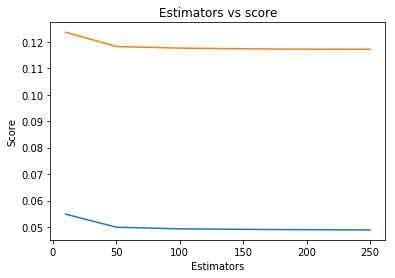

In [55]:
estimators = [10,50,100,175,250]
train_scores = []
test_scores = []
for i in estimators:
  clf = RandomForestRegressor(n_estimators=i, min_samples_split=4, n_jobs=-1)
  clf.fit(df_train, tsne_train_output)
  train_sc = calc_MAPE(tsne_train_output,clf.predict(df_train))
  test_sc = calc_MAPE(tsne_test_output,clf.predict(df_test))
  test_scores.append(test_sc)
  train_scores.append(train_sc)
  print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score')

Depths =  3 Train Score 0.16192714763533733 test Score 0.15180177439393988
Depths =  5 Train Score 0.12766156602817486 test Score 0.12095851757449985
Depths =  10 Train Score 0.12012001274781052 test Score 0.11783028051823466
Depths =  20 Train Score 0.09084533224337613 test Score 0.11726011269961327
Depths =  50 Train Score 0.04706327217774408 test Score 0.11855205833363403


Text(0.5, 1.0, 'Depths vs score')

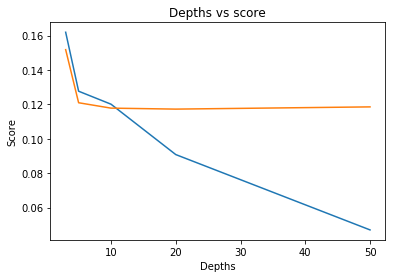

In [56]:
depths = [3,5,10,20, 50]
train_scores = []
test_scores = []
for i in depths:
  clf = RandomForestRegressor(n_estimators=40, max_depth=i, n_jobs=-1)
  clf.fit(df_train, tsne_train_output)
  train_sc = calc_MAPE(tsne_train_output,clf.predict(df_train))
  test_sc = calc_MAPE(tsne_test_output,clf.predict(df_test))
  test_scores.append(test_sc)
  train_scores.append(train_sc)
  print('Depths = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depths')
plt.ylabel('Score')
plt.title('Depths vs score')

**Taking `max_depth` and `n_estimators` values around the elbows of the graph. So, `max_depth` around 5, and `n_estimators` around 50.**

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [60]:
param_dist = {"n_estimators":sp_randint(40,70),
    "max_depth": sp_randint(4,7),
    "min_samples_split": sp_randint(2, 5)}

clf = RandomForestRegressor(n_jobs=-1)
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=5,scoring='neg_mean_squared_error',cv=10, return_train_score=True)
rf_random.fit(df_train, tsne_train_output)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

clf = rf_random.best_estimator_

print('Best Estimator: ', clf)

clf.fit(df_train, tsne_train_output)
y_train_pred = clf.predict(df_train)
y_test_pred = clf.predict(df_test)

print("Train MAPE: ", calc_MAPE(tsne_train_output,y_train_pred))
print("Test MAPE: ", calc_MAPE(tsne_test_output,y_test_pred))

mean test scores [-325.37889565 -284.00989898 -326.23933216 -326.21787578 -326.22011626]
mean train scores [-306.47715345 -278.59774775 -306.47150171 -306.26970892 -306.49969652]
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
Train MAPE:  0.12775629785820566
Test MAPE:  0.12092945844983294


In [64]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (clf.feature_importances_)

inds = np.argsort(clf.feature_importances_)
imp_cols = df_train.columns[inds[None:-10:-1]]
print(imp_cols)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'freq_0', 'amp_0', 'freq_1',
       'amp_1', 'freq_2', 'amp_2', 'freq_3', 'amp_3', 'freq_4', 'amp_4', 'lat',
       'lon', 'weekday', 'exp_avg', 'cluster_id'],
      dtype='object')
[2.74692769e-06 4.47063949e-05 7.34611639e-06 3.88654669e-06
 6.60703543e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.93334279e-01 0.00000000e+00]
Index(['exp_avg', 'ft_1', 'ft_4', 'ft_3', 'ft_2', 'ft_5', 'freq_0', 'amp_0',
       'freq_1'],
      dtype='object')


### Using XgBoost Regressor

[20:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Estimators =  10 Train Score 0.36788927885816347 test Score 0.3654381200688201
[20:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Estimators =  50 Train Score 0.12608815449389313 test Score 0.11959402341755858
[20:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Estimators =  100 Train Score 0.125303446022751 test Score 0.11925624463497128
[20:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Estimators =  250 Train Score 0.12394196743860231 test Score 0.11829708356340835
[20:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Estimators =  500 Train Score 0.12282390984398

Text(0.5, 1.0, 'Estimators vs score')

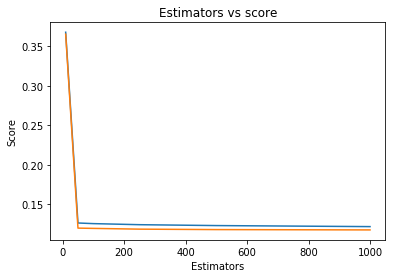

In [65]:
estimators = [10,50,100,250, 500, 1000]
train_scores = []
test_scores = []
for i in estimators:
  clf = xgb.XGBRegressor(
   learning_rate =0.1,
   n_estimators=i,
   max_depth=3,
   min_child_weight=3,
   gamma=0,
   subsample=0.8,
   reg_alpha=200, reg_lambda=200,
   colsample_bytree=0.8,nthread=4)
  clf.fit(df_train, tsne_train_output)
  train_sc = calc_MAPE(tsne_train_output,clf.predict(df_train))
  test_sc = calc_MAPE(tsne_test_output,clf.predict(df_test))
  test_scores.append(test_sc)
  train_scores.append(train_sc)
  print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score')

[20:30:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Depths =  3 Train Score 0.12282390984398615 test Score 0.11772948576887897
[20:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Depths =  5 Train Score 0.1195645236886165 test Score 0.11674756069142395
[20:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Depths =  8 Train Score 0.11351458624880534 test Score 0.11668544898648527
[20:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Depths =  10 Train Score 0.1083196457458951 test Score 0.11676210601079251
[20:41:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Depths =  15 Train Score 0.09386031458921193 test Score 0.11741859

Text(0.5, 1.0, 'Depths vs score')

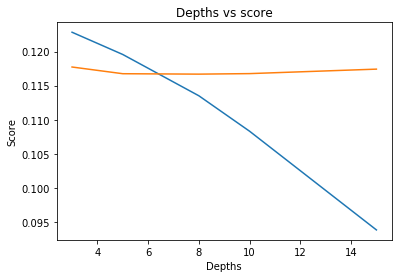

In [66]:
depths = [3, 5, 8, 10, 15]
train_scores = []
test_scores = []
for i in depths:
  clf = xgb.XGBRegressor(
   learning_rate =0.1,
   n_estimators=500,
   max_depth=i,
   min_child_weight=3,
   gamma=0,
   subsample=0.8,
   reg_alpha=200, reg_lambda=200,
   colsample_bytree=0.8,nthread=4)
  clf.fit(df_train, tsne_train_output)
  train_sc = calc_MAPE(tsne_train_output,clf.predict(df_train))
  test_sc = calc_MAPE(tsne_test_output,clf.predict(df_test))
  test_scores.append(test_sc)
  train_scores.append(train_sc)
  print('Depths = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depths')
plt.ylabel('Score')
plt.title('Depths vs score')

In [68]:
param_dist = {"n_estimators":sp_randint(40,70),
    "max_depth": sp_randint(5,9),
   "learning_rate": uniform(0.08, 0.12)}

clf = xgb.XGBRegressor(
   min_child_weight=3,
   gamma=0,
   subsample=0.8,
   reg_alpha=200, reg_lambda=200,
   colsample_bytree=0.8,nthread=4)
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,n_iter=5,scoring='neg_mean_squared_error',cv=10, return_train_score=True)
rf_random.fit(df_train, tsne_train_output)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

clf = rf_random.best_estimator_

print('Best Estimator: ', clf)

clf.fit(df_train, tsne_train_output)
y_train_pred = clf.predict(df_train)
y_test_pred = clf.predict(df_test)

print("Train MAPE: ", calc_MAPE(tsne_train_output,y_train_pred))
print("Test MAPE: ", calc_MAPE(tsne_test_output,y_test_pred))

[21:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:34:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

**Previous code cell's output is copied to markdown cell below as there are lot of deprecated warnings which are printed before the main output.**

<b>mean test scores [-356.7389414  -373.01542058 -357.75932091 -371.91452142 -336.10340613]
    
mean train scores [-255.30896492 -247.72946075 -249.17872772 -267.54641259 -259.16311609]</b>
<br>
<br>
<b>Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1865401918732345,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
             n_estimators=55, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=0, reg_alpha=200, reg_lambda=200, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

Train MAPE:  0.12342634088042077

Test MAPE:  0.11810948813003048</b>

In [75]:
clf.feature_importances_

array([5.98805782e-04, 4.98338020e-04, 3.75492312e-03, 1.88882221e-02,
       2.63216078e-01, 0.00000000e+00, 4.86344274e-04, 1.41845565e-04,
       3.44068947e-04, 1.80868126e-04, 1.74489905e-04, 4.80664239e-05,
       1.16007854e-04, 2.16440938e-04, 1.88977196e-04, 4.30918386e-04,
       5.04031486e-04, 1.84068573e-04, 7.09724247e-01, 3.03326320e-04],
      dtype=float32)

In [76]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (clf.feature_importances_)

inds = np.argsort(clf.feature_importances_)
imp_cols = df_train.columns[inds[None:-10:-1]]
print(imp_cols)
# inds = np.argsort(clf.feature_importances_)
# imp_cols = clf.columns[inds[None:-5:-1]]

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'freq_0', 'amp_0', 'freq_1',
       'amp_1', 'freq_2', 'amp_2', 'freq_3', 'amp_3', 'freq_4', 'amp_4', 'lat',
       'lon', 'weekday', 'exp_avg', 'cluster_id'],
      dtype='object')
[5.98805782e-04 4.98338020e-04 3.75492312e-03 1.88882221e-02
 2.63216078e-01 0.00000000e+00 4.86344274e-04 1.41845565e-04
 3.44068947e-04 1.80868126e-04 1.74489905e-04 4.80664239e-05
 1.16007854e-04 2.16440938e-04 1.88977196e-04 4.30918386e-04
 5.04031486e-04 1.84068573e-04 7.09724247e-01 3.03326320e-04]
Index(['exp_avg', 'ft_1', 'ft_2', 'ft_3', 'ft_5', 'lon', 'ft_4', 'amp_0',
       'lat'],
      dtype='object')


## Conclusion

**Printing a Table with MAPE values.**

In [3]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ['Model', 'hyper-parameters', 'Train MAPE', 'Test MAPE']
table.add_row(['Linear Regression', 'None', '12.5306 %', '11.9048 %'])
table.add_row(['Random Forest', 'n_estimators: 250, min_sample_slit: 4', '4.894 %', '11.7147 %'])
table.add_row(['Random Forest', 'n_estimators: 40, max_depth: 20', '9.0845 %', '11.726 %'])
table.add_row(['Random Forest', 'n_estimators: 41, max_depth: 5, min_sample_split: 2', '12.7756 %', '12.093 %'])
table.add_row(['XGBoost', 'n_estimators: 1000, max_depth: 3', '12.1504 %', '11.7317 %'])
table.add_row(['XGBoost', 'n_estimators: 500, max_depth: 8', '11.3514 %', '11.6685 %'])
table.add_row(['XGBoost', 'n_estimators: 55, max_depth: 5, learning_rate: 0.1865', '12.3426 %', '11.8109 %'])

print(table)

+-------------------+-------------------------------------------------------+------------+-----------+
|       Model       |                    hyper-parameters                   | Train MAPE | Test MAPE |
+-------------------+-------------------------------------------------------+------------+-----------+
| Linear Regression |                          None                         | 12.5306 %  | 11.9048 % |
|   Random Forest   |         n_estimators: 250, min_sample_slit: 4         |  4.894 %   | 11.7147 % |
|   Random Forest   |            n_estimators: 40, max_depth: 20            |  9.0845 %  |  11.726 % |
|   Random Forest   |  n_estimators: 41, max_depth: 5, min_sample_split: 2  | 12.7756 %  |  12.093 % |
|      XGBoost      |            n_estimators: 1000, max_depth: 3           | 12.1504 %  | 11.7317 % |
|      XGBoost      |            n_estimators: 500, max_depth: 8            | 11.3514 %  | 11.6685 % |
|      XGBoost      | n_estimators: 55, max_depth: 5, learning_rate: 0.18

**In above models, sklearn's LinearRegression doesnt have any hyper-parameters to tune so there are None. For Random Forest, remaining hyper-parameters which are not mentioned here are default values of the sklearn's Random Forest. For XGBoost, remaining hyper-parameters which are not mentioned here are taken from the original notebook's XGBoost model. Hyper-parameters of third Random Forest model and XGBoost model are tuned using sklearn's RandomSearchCV.**

**Conclusion:**
- **Among all models XGBoost with n_estimators: 500 and max_depth: 8 gave very good results. And also Random Forest model with n_estimators: 40 and max_depth: 20 gave good results.**
- **The training data is one-hot encoded before passing it to Linear regression model as the cluster centers and weekday are not linearly dependent on the output i.e. number of cabs booked. For tree based models encoding is not done as they can handle non-linear relation between input and output and also tree based models will not perform good with high-dimentional data and sparse data.**
- **Random Forest models for which max-depth is not tuned are overfitting a lot.**
- **When important features abserved in both Random forest and XGBoost exponential moving average output and previous 10-min intervals data seems to be very important. And in XGBoost we can see latitude data and longitude data and a fourier data (amplitude of highest frequency) seems to be important. Below I print top features for both models.**

**Important features for Random Forest: ['exp_avg', 'ft_1', 'ft_4', 'ft_3', 'ft_2', 'ft_5']**

**Important features for XGBoost: ['exp_avg', 'ft_1', 'ft_2', 'ft_3', 'ft_5', 'lon', 'ft_4', 'amp_0', 'lat']**